<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span><ul class="toc-item"><li><span><a href="#Pokemon-Dataset-Download-and-normalization" data-toc-modified-id="Pokemon-Dataset-Download-and-normalization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pokemon Dataset Download and normalization</a></span></li></ul></li><li><span><a href="#Networks" data-toc-modified-id="Networks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Networks</a></span><ul class="toc-item"><li><span><a href="#Discriminator" data-toc-modified-id="Discriminator-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Discriminator</a></span></li><li><span><a href="#Generator" data-toc-modified-id="Generator-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Generator</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span></li></ul></div>

## Initialization

In [1]:
import numpy as np
import os
import sys
import torch
from torch import nn, optim
from torch.autograd.variable import Variable as V
from torchvision import datasets, transforms, models, transforms, utils
from matplotlib import pyplot as plt
from matplotlib import gridspec

In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
print(sys.version) # Python version
print(torch.cuda.device(0))
torch.cuda.get_device_name(0)

3.6.6 | packaged by conda-forge | (default, Oct 12 2018, 14:08:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


'GeForce GTX 1060'

In [3]:
seed=30
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  30


### Pokemon Dataset Download and normalization

In [4]:
# Datasets
data_dir='pokemon_dataset/'

# Batch Size
bs=64

# Normalization parameters Imagenet
means=[0.485, 0.456, 0.406]
standard_deviations=[0.229, 0.224, 0.225]

data_transforms=transforms.Compose([transforms.CenterCrop(160),
                                    transforms.ToTensor(),
                                    transforms.Normalize(means,standard_deviations)])    

# ImageFolder
image_dataset=datasets.ImageFolder(root=data_dir,transform=data_transforms)

# DataLoaders
dataloader=torch.utils.data.DataLoader(dataset=image_dataset,
                                       batch_size=bs,shuffle=True,drop_last=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


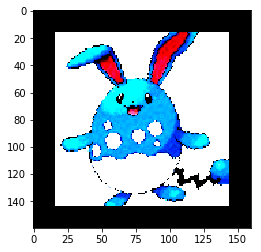

In [5]:
# Sample Image
images,labels=next(iter(dataloader))
image=images[0].permute(1,2,0).numpy()

plt.imshow(image)

## Networks

### Discriminator

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        n_features= 784 # Flattened 28*28 image
        n_out=1 # Bool Real or Generated image
        
        self.Conv1=nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.SELU()
        )
        
        self.Conv2=nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.SELU()
        )
        
        self.Conv3=nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.SELU()
        )
        
        self.out=nn.Sequential(
            nn.Linear(10248*4*4, 1),
            nn.Sigmoid(),
        
        )
        
        self.optimizer=optim.Adam(self.parameters(), lr=0.00002)
    
    def forward(self, x):
        x=self.Conv1(x)
        x=self.Conv2(x)
        x=self.Conv3(x)
        x=x.view(-1,1024*4*4)
        x=self.out(x)
        return x
    
    def train(self, real_data, false_data):
        self.optimizer.zero_grad() # Zero/ Reset all gradients
        loss=nn.BCELoss() # Binary Cross-Entropy Loss
        
        # Real data training
        prediction_real=self(real_data) # Prediction
        real_ones_data=V(torch.ones(real_data.size(0),1)).cuda() # Label ones
        error_real=loss(prediction_real,real_ones_data)
        error_real.backward()
        
        # Fake data training
        prediction_false=self(false_data) # Prediction on generated data
        real_zeros_data=V(torch.zeros(false_data.size(0),1)).cuda() # Label zeros
        error_false=loss(prediction_false,real_zeros_data)
        error_false.backward() # Backprop error
        
        self.optimizer.step() # Update weights of Adam
        
        return error_real+error_false,prediction_real,prediction_false # Error, predictions

### Generator

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        n_features=100 # Latent variable vector size
        n_out=784 # 28*28 input image
                
        self.hidden0=nn.Sequential(
            nn.Linear(n_features,256),
            nn.SELU()
        )
        self.hidden1=nn.Sequential(
            nn.Linear(256,512),
            nn.SELU(),
            nn.Dropout(0.25)
        )
        self.hidden2=nn.Sequential(
            nn.Linear(512,1024),
            nn.SELU(),
            nn.Dropout(0.25)
        )
        self.out=nn.Sequential(
            nn.Linear(1024,n_out),
            nn.Tanh()
        )
        
        self.optimizer=optim.Adam(self.parameters(), lr=0.00002)
    
    def forward(self, x):
        x=self.hidden0(x)
        x=self.hidden1(x)
        x=self.hidden2(x)
        x=self.out(x)
        return x
    
    def train(self, discriminator, false_data):
        self.optimizer.zero_grad() # Zero/ Reset all gradients
        loss=nn.BCELoss() # Binary Cross-Entropy Loss
        
        prediction=discriminator(false_data)
        real_ones_data=V(torch.ones(false_data.size(0),1)).cuda()
        error=loss(prediction, real_ones_data)
        error.backward() # Backprop error
        
        self.optimizer.step() # Update weights of Adam
    
        return error       

## Training 

In [ ]:
def sample_noise(sample_size, latent_vec_size):
    return V(torch.randn(sample_size, latent_vec_size)).cuda()



In [ ]:
n_epochs=500
total_steps=len(mnist_dataloader)
generated_folder='generated_images/'
weights_model_folder='trained_folder/'

discriminator=Discriminator()
generator=Generator()

print("-----Discriminator-----")
print(discriminator,"\n")
print("-----Generator-----")
print(generator,"\n")

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

print("Training...")

for epoch in range(n_epochs):
    for index, (real_data_batch, _) in enumerate(mnist_dataloader):
        data_batch_size=real_data_batch.size(0)
        
        real_data_batch=V(real_data_batch.view(data_batch_size,784)) # Vectorize+ Variable
        real_data_batch=real_data_batch.cuda() # Cuda compatible
        
        false_data=generator(sample_noise(data_batch_size,100)).detach() # Generate false data...
        # but avoid discriminator gradients being updated by this
        
        dis_error, dis_prediction_real, dis_prediction_false=discriminator.train(real_data_batch, false_data) # Discriminator training
        
        false_data=generator(sample_noise(data_batch_size,100)) # Generate more false data
        gen_error=generator.train(discriminator, false_data) # Generator train
        
        if index%128==0: # Every minibatch
            print("\nEpoch {}, Batch {}\n".format(epoch,index))
            print("\tDiscriminator Error: {}, Generator Error: {}".format(dis_error,gen_error))
    
    if epoch%10==0: # Every 10 epochs
        generated_noise=sample_noise(20,100) # For generated image sample, noise vector
        generator_vec=generator(generated_noise) # Using the same generated noise vector
        sample_images=generator_vec.view(generator_vec.size(0),1,28,28).data
        
        fig=plt.figure(figsize=(8,10))
        gs=gridspec.GridSpec(4,5)
        gs.update(wspace=0.05, hspace=0.05)
        
        
        for i, sample_image in enumerate(sample_images):
            ax=plt.subplot(gs[i])
            plt.axis('off')
            plt.imshow(sample_image.cpu().reshape(28,28), cmap='Greys_r')
            
        if not os.path.exists(generated_folder):
            os.makedirs(generated_folder)
          
        figure_name="{}Epoch_{}.png".format(generated_folder, epoch)
        plt.savefig(figure_name, bbox_inches='tight')
        print("Saved {}".format(figure_name))
        
    if epoch%50==0:
        if not os.path.exists(weights_model_folder):
            os.makedirs(weights_model_folder)
        
        filepath_generator="{}generator_epoch{}".format(weights_model_folder, epoch)
        filepath_discriminator="{}discriminator_epoch{}".format(weights_model_folder, epoch)
        
        torch.save(generator, filepath_generator)
        torch.save(discriminator, filepath_discriminator)
        
        
plt.close(fig)